In [1]:
import random
from pathlib import Path
from math import sqrt, pi

import numpy as np
#from scipy.stats import ttest_rel, ttest_ind, wilcoxon
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# Load in all csv result files & combine them to one pandas table
wells = ['C' + '{0:02d}'.format(x) for x in range(3,11)] + \
        ['D' + '{0:02d}'.format(x) for x in range(3,11)] + \
        ['E' + '{0:02d}'.format(x) for x in range(3,11)] + \
        ['F' + '{0:02d}'.format(x) for x in range(3,11)]

base_path = '/Users/Joel/shares/workShareJoel/20181203-bDNA-FISH-8-feature-values-improved/20181203-bDNA-FISH-8_p1_'

results = pd.DataFrame()

for well in wells:
    curr_features = pd.read_csv(base_path + well + '_Cells_feature-values.csv')
    curr_metadata = pd.read_csv(base_path + well + '_Cells_metadata.csv')
    curr_well = curr_features.merge(curr_metadata, on = ['mapobject_id'])
    results = pd.concat([results, curr_well])

# print(results.head())
print(results.columns.values)

['mapobject_id' 'Nuclei_Intensity_max_DAPI' 'Nuclei_Intensity_mean_DAPI'
 'Nuclei_Intensity_min_DAPI' 'Nuclei_Intensity_sum_DAPI'
 'Nuclei_Intensity_std_DAPI' 'Intensity_max_DAPI' 'Intensity_mean_DAPI'
 'Intensity_min_DAPI' 'Intensity_sum_DAPI' 'Intensity_std_DAPI'
 'Intensity_max_Succs' 'Intensity_mean_Succs' 'Intensity_min_Succs'
 'Intensity_sum_Succs' 'Intensity_std_Succs' 'Intensity_max_DDX6'
 'Intensity_mean_DDX6' 'Intensity_min_DDX6' 'Intensity_sum_DDX6'
 'Intensity_std_DDX6' 'Intensity_max_bDNA-FISH' 'Intensity_mean_bDNA-FISH'
 'Intensity_min_bDNA-FISH' 'Intensity_sum_bDNA-FISH'
 'Intensity_std_bDNA-FISH' 'Nuclei_Morphology_Area'
 'Nuclei_Morphology_Eccentricity' 'Nuclei_Morphology_Convexity'
 'Nuclei_Morphology_Circularity' 'Nuclei_Morphology_Perimeter'
 'Nuclei_Morphology_Elongation' 'Morphology_Area'
 'Morphology_Eccentricity' 'Morphology_Convexity' 'Morphology_Circularity'
 'Morphology_Perimeter' 'Morphology_Elongation' 'mRNA_T1_Count_bDNA-FISH'
 'mRNA_T1_Mean_Intensity_max_

In [3]:
# Filter out cells that are thrown out by SVM
no_blobs = (results['FISH-Blobs'] == 0)
correct_segment = (results['Missegmented'] == 0)
non_mitotic = (results['Mitotic'] == 0)
non_border_cells = (results['is_border'] == 0)

# Filter out cells that have very low DAPI signal. Mostly missegmented HEK cells
normal_dapi = (results['Nuclei_Intensity_sum_DAPI'] < 12000000) & (results['Nuclei_Intensity_sum_DAPI'] > 2000000)
# Filter out huge cells (missegmented cells)
normal_area = (results['Morphology_Area'] < 125000)

results_cleaned = results.loc[no_blobs & correct_segment & non_mitotic & non_border_cells & normal_dapi & normal_area]

print('Filtered out {} cells, kept {} ({:.2f}%)'.format(results.shape[0] - results_cleaned.shape[0], results_cleaned.shape[0], results_cleaned.shape[0]/results.shape[0] *100))


Filtered out 63634 cells, kept 97703 (60.56%)


In [4]:
# Define well sub-selections
hela = ['C' + '{0:02d}'.format(x) for x in range(3,11)] + \
       ['D' + '{0:02d}'.format(x) for x in range(3,11)]
hek = ['E' + '{0:02d}'.format(x) for x in range(3,11)] + \
      ['F' + '{0:02d}'.format(x) for x in range(3,11)]

hela_cells = (results_cleaned['well_name'].isin(hela))
hek_cells = (results_cleaned['well_name'].isin(hek))

hela_C_row = (results_cleaned['well_name'].isin(['C' + '{0:02d}'.format(x) for x in range(3,11)]))
hek_E_row = (results_cleaned['well_name'].isin(['E' + '{0:02d}'.format(x) for x in range(3,11)]))

hela_T1 = ['C' + '{0:02d}'.format(x) for x in range(3,9)]  #+ \
#           ['D' + '{0:02d}'.format(x) for x in range(3,9)]
hek_T1 = ['E' + '{0:02d}'.format(x) for x in range(3,9)] #+ \
#          ['F' + '{0:02d}'.format(x) for x in range(3,9)]

hela_T4 = ['C' + '{0:02d}'.format(x) for x in range(9,11)]
hek_T4 = ['E' + '{0:02d}'.format(x) for x in range(9,11)]

hela_cells_T1 = (results_cleaned['well_name'].isin(hela_T1))
hek_cells_T1 = (results_cleaned['well_name'].isin(hek_T1))
hela_cells_T4 = (results_cleaned['well_name'].isin(hela_T4))
hek_cells_T4 = (results_cleaned['well_name'].isin(hek_T4))

In [5]:
# Create a combined mRNA spot count column for total count & count in Pbodies (col 3-8 => T1, col 9 & 10 => T4)
results_cleaned = results_cleaned.assign(mRNA_Pbody_Count = results_cleaned['mRNA_Pbody_T1_Count'])
results_cleaned.loc[(hela_cells_T4 | hek_cells_T4),'mRNA_Pbody_Count'] = results_cleaned['mRNA_Pbody_T4_Count'][hela_cells_T4 | hek_cells_T4]
results_cleaned = results_cleaned.assign(mRNA_Count = results_cleaned['mRNA_T1_Count_bDNA-FISH'])
results_cleaned.loc[(hela_cells_T4 | hek_cells_T4),'mRNA_Count'] = results_cleaned['mRNA_T4_Count_bDNA-FISH'][hela_cells_T4 | hek_cells_T4]


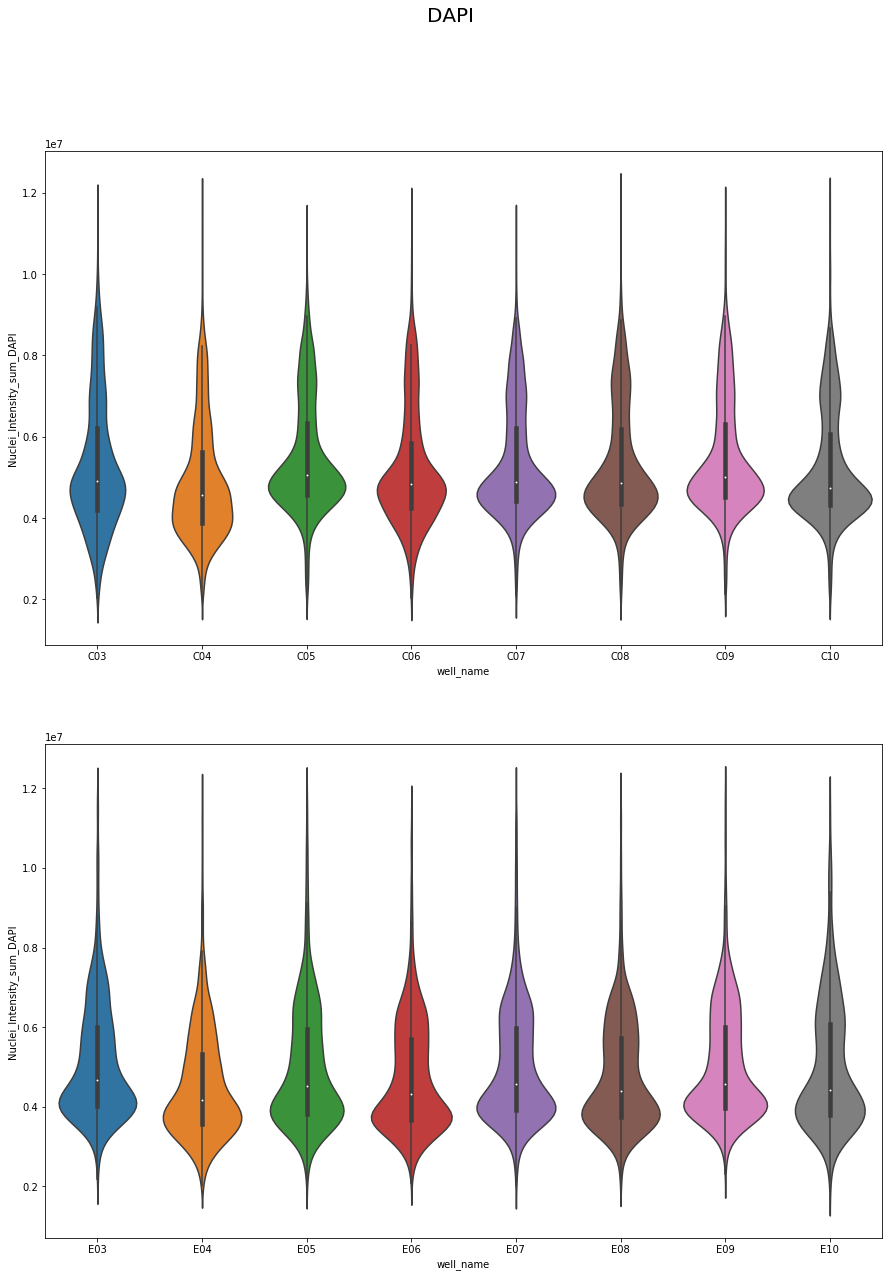

In [7]:
# Make some quality control plots
# DAPI violin plots
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
fig1.suptitle('DAPI', fontsize = 20)
sns.violinplot(x = 'well_name', y = 'Nuclei_Intensity_sum_DAPI', data = results_cleaned.loc[hela_C_row], ax=ax1[0])
sns.violinplot(x = 'well_name', y = 'Nuclei_Intensity_sum_DAPI', data = results_cleaned.loc[hek_E_row], ax=ax1[1])

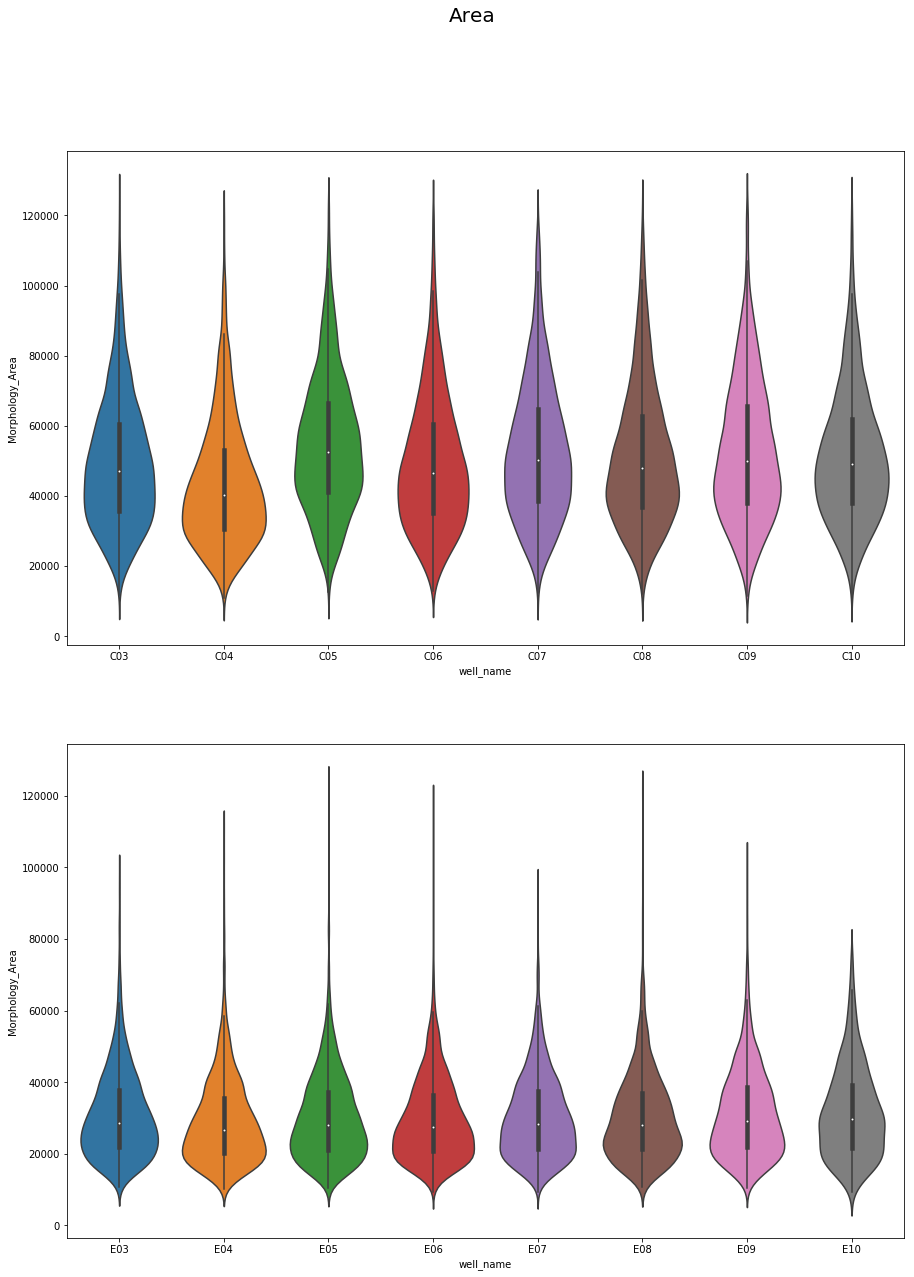

In [8]:
# Area violin plots
fig2, ax2 = plt.subplots(2, 1, figsize=(15, 20))
fig2.suptitle('Area', fontsize = 20)
sns.violinplot(x = 'well_name', y = 'Morphology_Area', data = results_cleaned.loc[hela_C_row], ax=ax2[0])
sns.violinplot(x = 'well_name', y = 'Morphology_Area', data = results_cleaned.loc[hek_E_row], ax=ax2[1])

(-5, 250)

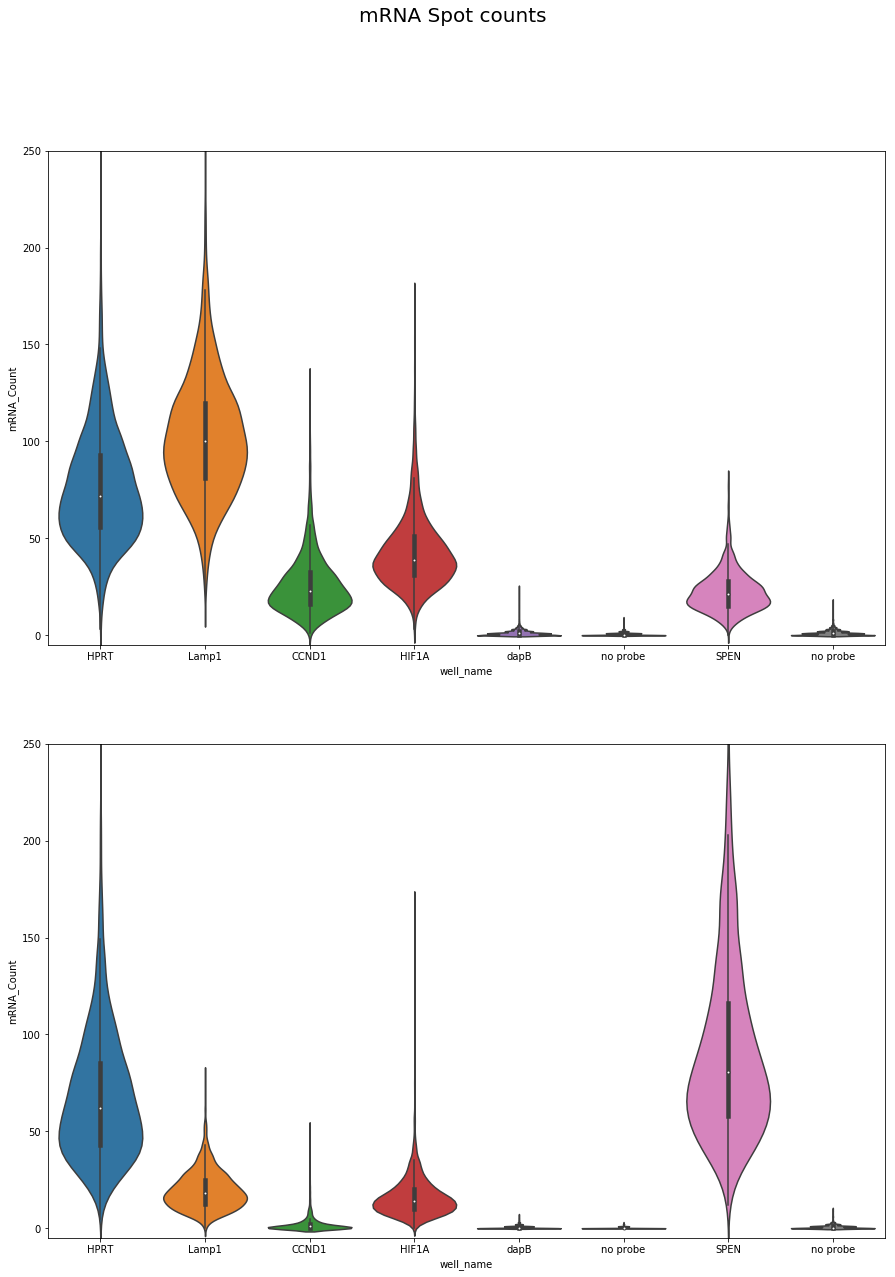

In [11]:
# plot transcript numbers per cell, comparing replicates
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
fig1.suptitle('mRNA Spot counts', fontsize = 20)
g = sns.violinplot(x = 'well_name', y = 'mRNA_Count', data = results_cleaned.loc[hela_C_row], ax=ax1[0], scale = 'width')
g.set(xticklabels=['HPRT', 'Lamp1', 'CCND1', 'HIF1A', 'dapB', 'no probe', 'SPEN', 'no probe'])
h = sns.violinplot(x = 'well_name', y = 'mRNA_Count', data = results_cleaned.loc[hek_E_row], ax=ax1[1], scale = 'width')
h.set(xticklabels=['HPRT', 'Lamp1', 'CCND1', 'HIF1A', 'dapB', 'no probe', 'SPEN', 'no probe'])
ax1[0].set_ylim(-5,250)
ax1[1].set_ylim(-5,250)



In [12]:
# Calculate average spot counts per well 
print(results_cleaned.groupby('well_name')['mRNA_Count'].median())

print(results_cleaned.groupby('well_name')['mRNA_Pbody_Count'].mean())

well_name
C03     72.0
C04    100.0
C05     23.0
C06     39.0
C07      1.0
C08      0.0
C09     21.0
C10      1.0
D03     66.0
D04    137.0
D05     47.0
D06     49.0
D07      2.0
D08      1.0
D09      9.0
D10      0.0
E03     62.0
E04     18.0
E05      1.0
E06     14.0
E07      0.0
E08      0.0
E09     80.5
E10      0.0
F03     66.0
F04     36.0
F05      2.0
F06     11.0
F07      1.0
F08      0.0
F09     17.0
F10      0.0
Name: mRNA_Count, dtype: float64
well_name
C03    0.689192
C04    0.656059
C05    0.310642
C06    0.466597
C07    0.005224
C08    0.002001
C09    0.158309
C10    0.002334
D03    0.679908
D04    0.869828
D05    0.650221
D06    0.561520
D07    0.014630
D08    0.004386
D09    0.069395
D10    0.000329
E03    0.963357
E04    0.247243
E05    0.026316
E06    0.259936
E07    0.004461
E08    0.003702
E09    0.948509
E10    0.009756
F03    0.917505
F04    0.464736
F05    0.077617
F06    0.178828
F07    0.006875
F08    0.004045
F09    0.269558
F10    0.000000
Name: mRNA_Pbody_Co

In [13]:
# Look at percentage of transcripts in P-bodies
results_cleaned = results_cleaned.assign(percentage_pbody_2 = 0)
cells_with_pbodies = results_cleaned['mRNA_Count'] >= 1
results_cleaned.loc[cells_with_pbodies,'percentage_pbody'] = results_cleaned['mRNA_Pbody_Count'][cells_with_pbodies]/results_cleaned['mRNA_Count'][cells_with_pbodies]
print(results_cleaned['percentage_pbody'].describe())


count    77409.000000
mean         0.008937
std          0.035138
min          0.000000
25%          0.000000
50%          0.000000
75%          0.007463
max          1.000000
Name: percentage_pbody, dtype: float64


[[Text(0, 0, 'HPRT'),
  Text(0, 0, 'Lamp1'),
  Text(0, 0, 'CCND1'),
  Text(0, 0, 'HIF1A'),
  Text(0, 0, 'dapB'),
  Text(0, 0, 'no probe'),
  Text(0, 0, 'SPEN'),
  Text(0, 0, 'no probe')]]

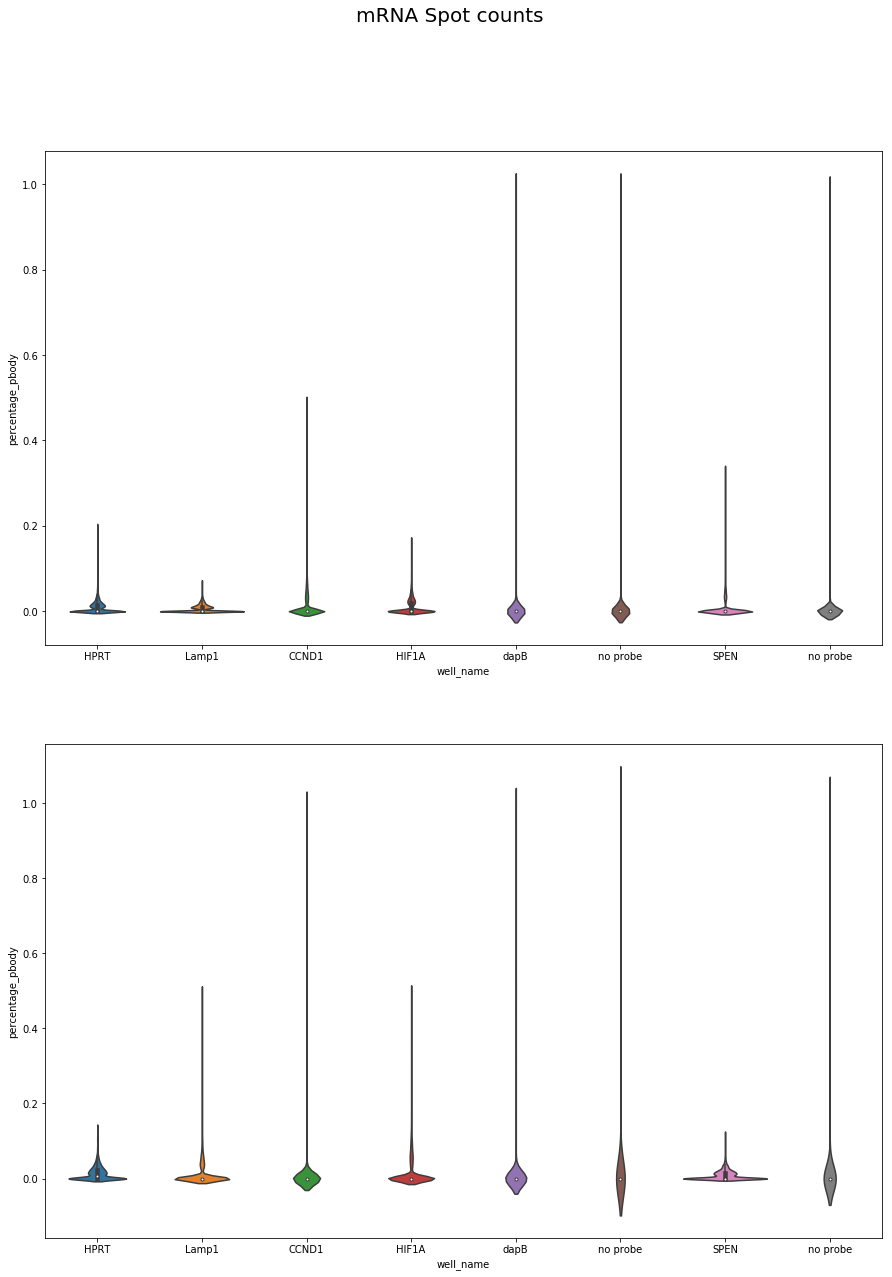

In [14]:
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
fig1.suptitle('mRNA Spot counts', fontsize = 20)
g = sns.violinplot(x = 'well_name', y = 'percentage_pbody', data = results_cleaned.loc[hela_C_row], ax=ax1[0])
g.set(xticklabels=['HPRT', 'Lamp1', 'CCND1', 'HIF1A', 'dapB', 'no probe', 'SPEN', 'no probe'])
h = sns.violinplot(x = 'well_name', y = 'percentage_pbody', data = results_cleaned.loc[hek_E_row], ax=ax1[1])
h.set(xticklabels=['HPRT', 'Lamp1', 'CCND1', 'HIF1A', 'dapB', 'no probe', 'SPEN', 'no probe'])


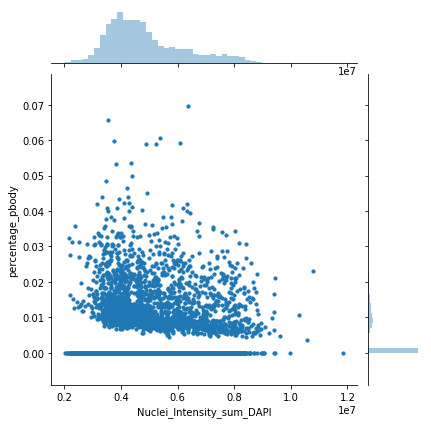

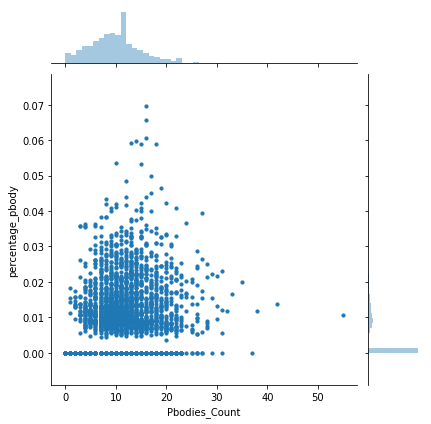

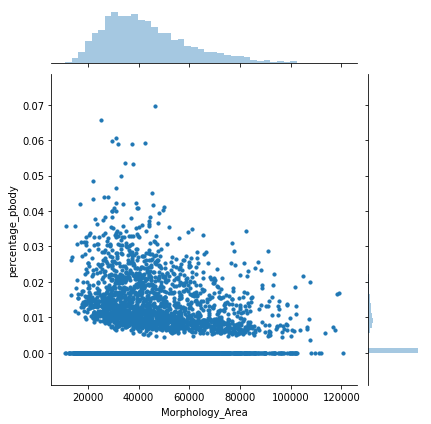

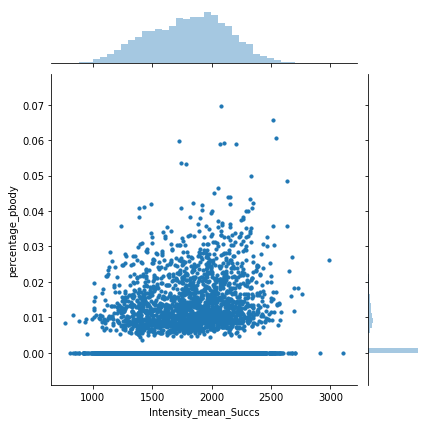

In [18]:
# Plot percentage P-bodies vs cellular features (area, #Pbodies total, DNA content, protein content)
# fig1, ax1 = plt.subplots(2, 2, figsize=(15, 15))
# fig1.suptitle('Percentage Pbodies vs. cell Features', fontsize = 20)
# SPEN_hek = results_cleaned['well_name'] == 'E09'
# sns.jointplot(x = 'Nuclei_Intensity_sum_DAPI', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,], s=10)
# sns.jointplot(x = 'Pbodies_Count', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,],s=10)
# sns.jointplot(x = 'Morphology_Area', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,],s=10)
# sns.jointplot(x = 'Intensity_mean_Succs', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,],s=10)

# CCND1_hela = results_cleaned['well_name'] == 'C05'
# g = sns.jointplot(x = 'Nuclei_Intensity_sum_DAPI', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,], s=10)
# sns.jointplot(x = 'Pbodies_Count', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,],s=10)
# sns.jointplot(x = 'Morphology_Area', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,],s=10)
# sns.jointplot(x = 'Intensity_mean_Succs', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,],s=10)

lamp1_hela = results_cleaned['well_name'] == 'C04'
g = sns.jointplot(x = 'Nuclei_Intensity_sum_DAPI', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,], s=10)
sns.jointplot(x = 'Pbodies_Count', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,],s=10)
sns.jointplot(x = 'Morphology_Area', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,],s=10)
sns.jointplot(x = 'Intensity_mean_Succs', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,],s=10)


In [20]:
# Save dataframe as csv
results_cleaned.to_csv('20181203-bDNA-FISH8-results-cleaned_improved.csv')

Load data directly from TissueMaps for single wells

In [26]:
import tmclient
host="172.23.47.46"
port = 80
experimentName="20181203-bDNA-FISH-8"
username="joel"
password="123456"
mapobject="Cells"
client = tmclient.TmClient(host, port, username, password, experimentName)

plateDownload = client.get_plates()
plate_name = plateDownload[0]['name']

wells = ['C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'E03', 'E08']
for well in wells:
    print(well)
    site_y = 0
    for site_x in range(1,3):
        feature_values = client.download_feature_values(mapobject, plate_name, well, site_y, site_x)
        print(feature_values['mRNA_T1_Count_bDNA-FISH'].mean())
#         print(feature_values['mRNA_Pbody_T1_Count'].mean())

wells = ['C09', 'C10']
for well in wells:
    print(well)
    site_y = 0
    for site_x in range(1,3):
        feature_values = client.download_feature_values(mapobject, plate_name, well, site_y, site_x)
        print(feature_values['mRNA_T4_Count_bDNA-FISH'].mean()) 

C03
81.61333333333333
162.75524475524475
C04
91.1875
241.82978723404256
C05
35.64705882352941
60.42727272727273
C06
54.68493150684932
83.32038834951456
C07
2.1403508771929824
8.844660194174757
C08
0.47058823529411764
2.2905982905982905
E03
97.74468085106383
196.3235294117647
E08
2.888888888888889
1.0714285714285714
C09
17.56451612903226
30.93548387096774
C10
0.9247311827956989
1.7032967032967032
